In [1]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

fatal: destination path 'new-simple-point-clouds' already exists and is not an empty directory.


In [2]:
pip install matplotlib

In [3]:
!pip install plyfile

In [4]:
pip install torch

In [5]:
pip install numpy torch trimesh open3d

In [6]:
!pip install rtree

In [7]:
import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

In [8]:
def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

In [10]:
# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

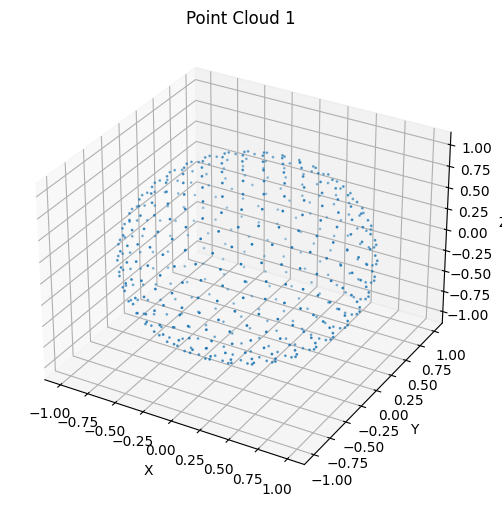

In [11]:
plot_point_cloud(point_clouds[6], title=f"Point Cloud 1")
plt.show()

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import trimesh
import open3d as o3d

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Reconstruct a surface mesh from a point cloud
def reconstruct_surface_mesh(point_cloud):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radii = [avg_dist, avg_dist * 2]
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))
    return mesh

# Prepare SDF training data
def prepare_sdf_training_data(mesh, num_samples=10000):
    # Convert Open3D mesh to Trimesh
    vertices = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.triangles)
    trimesh_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Sample points around the mesh
    bounds = trimesh_mesh.bounds
    sample_points = np.random.rand(num_samples, 3) * (bounds[1] - bounds[0]) + bounds[0]

    # Compute SDF values
    sdf_values = trimesh.proximity.signed_distance(trimesh_mesh, sample_points)
    return torch.tensor(sample_points, dtype=torch.float32), torch.tensor(sdf_values, dtype=torch.float32).unsqueeze(1)

# Training Procedure
def train_mlp_on_sdf(model, train_points, train_sdf, epochs=1000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(train_points)
        loss = criterion(predictions, train_sdf)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Load your point cloud
point_cloud_data = point_clouds[6]

# Reconstruct mesh and prepare SDF training data
mesh = reconstruct_surface_mesh(point_cloud_data)
train_points, train_sdf = prepare_sdf_training_data(mesh)

# Normalize train_points for better MLP training performance
train_points_mean = train_points.mean(0)
train_points_std = train_points.std(0)
train_points = (train_points - train_points_mean) / train_points_std

# Initialize and train the MLP model
model = MLP(input_dim=3, output_dim=1)
train_mlp_on_sdf(model, train_points, train_sdf)

visualize_with_marching_cubes(model)

Epoch 0, Loss: 0.08114991337060928
Epoch 10, Loss: 0.06324080377817154
Epoch 20, Loss: 0.05424238368868828
Epoch 30, Loss: 0.0455368235707283
Epoch 40, Loss: 0.037468571215867996
Epoch 50, Loss: 0.03162464126944542
Epoch 60, Loss: 0.02827269956469536
Epoch 70, Loss: 0.026188287883996964
Epoch 80, Loss: 0.02476477064192295
Epoch 90, Loss: 0.02367420122027397
Epoch 100, Loss: 0.022755175828933716
Epoch 110, Loss: 0.021963192149996758
Epoch 120, Loss: 0.021511448547244072
Epoch 130, Loss: 0.020790206268429756
Epoch 140, Loss: 0.0203506201505661
Epoch 150, Loss: 0.019938191398978233
Epoch 160, Loss: 0.019582100212574005
Epoch 170, Loss: 0.019245360046625137
Epoch 180, Loss: 0.01893489807844162
Epoch 190, Loss: 0.01888352446258068
Epoch 200, Loss: 0.018482912331819534
Epoch 210, Loss: 0.01823311857879162
Epoch 220, Loss: 0.018036192283034325
Epoch 230, Loss: 0.017856966704130173
Epoch 240, Loss: 0.017681626603007317
Epoch 250, Loss: 0.017679458484053612
Epoch 260, Loss: 0.017531145364046097

In [18]:
def visualize_with_marching_cubes(model, grid_size=50):
    # Generate a grid of points
    grid_points = np.linspace(-1, 1, grid_size)
    x, y, z = np.meshgrid(grid_points, grid_points, grid_points)
    grid_shape = x.shape
    xyz = torch.FloatTensor(np.stack([x.ravel(), y.ravel(), z.ravel()], axis=-1))

    # Normalize the points as done during training
    xyz_norm = (xyz - train_points_mean) / train_points_std

    # Predict SDF values for the grid
    with torch.no_grad():
        sdf_pred = model(xyz_norm).numpy().reshape(grid_shape)

    # Determine an appropriate level within the SDF value range
    sdf_min, sdf_max = sdf_pred.min(), sdf_pred.max()
    level = 0  # Default, but check if it's within range
    if level < sdf_min or level > sdf_max:
        print(f"Adjusting level from {level} to midpoint of SDF range.")
        level = sdf_min + (sdf_max - sdf_min) / 2

    # Marching Cubes to find surfaces
    verts, faces, _, _ = measure.marching_cubes(sdf_pred, level=level)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlim([0, grid_size])
    ax.set_ylim([0, grid_size])
    ax.set_zlim([0, grid_size])
    plt.tight_layout()
    plt.show()


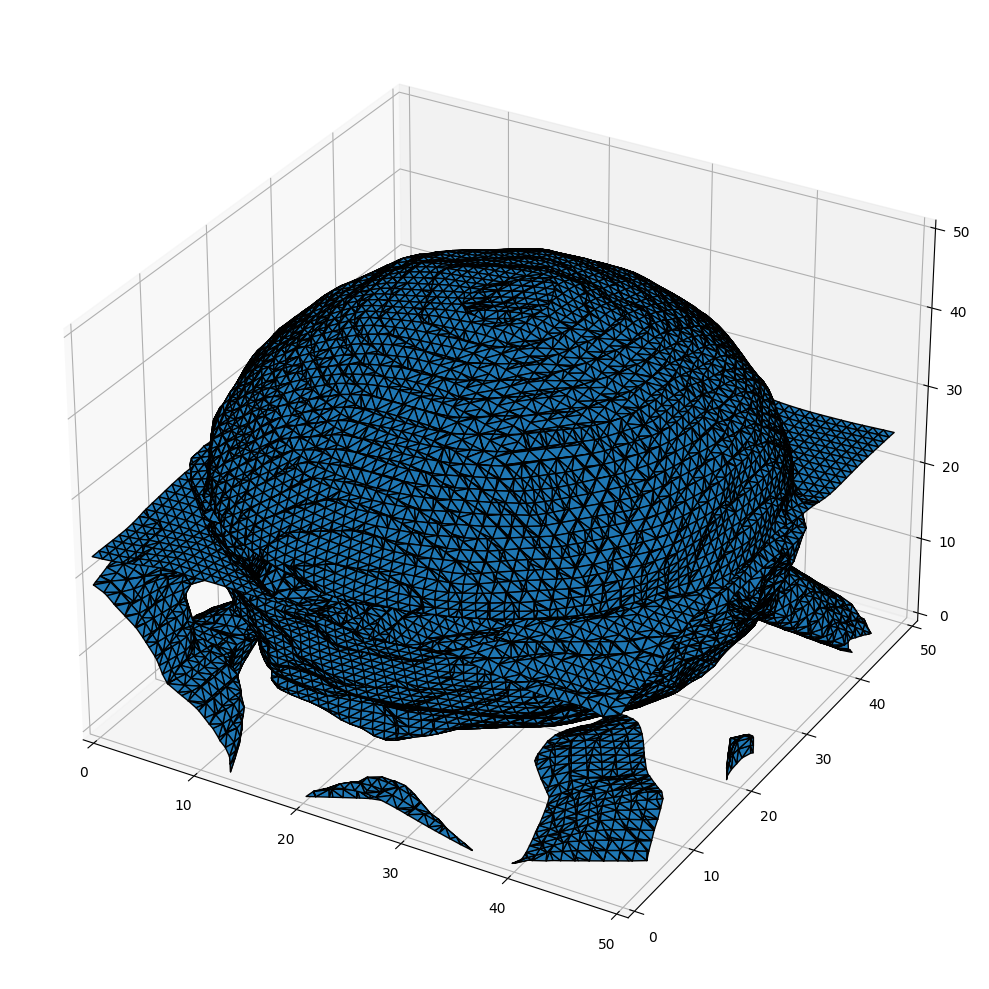

In [14]:
visualize_with_marching_cubes(model)